## Table of Contents

1. [BMW F34](#BMW-F34-Insights)
2. [AUDI A4 B6](#AUDI-A4-B6)
3. [VOLVO XC60 I](#VOLVO-XC60-I)
4. [Ford S-MAX I](#Ford-S-MAX-I)
5. [Kia Carnival III](#Kia-Carnival-III)
6. [Subaru Impreza III](#Subaru-Impreza-III)
7. [Subaru Impreza III Автомат](#Subaru-Impreza-III-Автомат)
8. [BMW X1 E84](#BMW-X1-E84)
8. [Volvo S40 II](#Volvo-S40-II)

In [1]:
from datetime import datetime
from collections import defaultdict
from matplotlib import pyplot as plt
from itertools import groupby
import json
from IPython.display import display, HTML

# Load the 'history' file
with open('history', 'r') as file:
	history = [json.loads(line) for line in file if line.strip()]

def parse_datetime(datetime_str):
		# 2025-03-23T17:02:56+0300 -> 2025-03-23T17:02:56+03:00
		datetime_str_fixed = datetime_str[:22] + ':' + datetime_str[22:]
		return datetime.fromisoformat(datetime_str_fixed)

def find_by_id(id):
	return next((item for item in history if item['id'] == id), None)

def plot_price_by_date(history, model):
	# Group data by car ID and prepare data for plotting
	car_data = defaultdict(list)

	for record in history:
		car_id = record['id']
		price = record['price']['usd']['amount']
		date = parse_datetime(record['downloadDate'])
		car_data[car_id].append((date, price))

	# Plot the data
	plt.figure(figsize=(12, 16))

	for car_id, data in car_data.items():
		data.sort(key=lambda x: x[0])  # Sort by date
		dates, prices = zip(*data)
		plt.plot(dates, prices, marker='o', linestyle='-')
		plt.text(dates[-1], prices[-1], f'id: {car_id}', fontsize=9, ha='left', va='center')

	plt.title(f'График цен {model} с разбивкой по id')
	plt.xlabel('Время')
	plt.ylabel('Цена')
	plt.xticks(rotation=45)
	plt.grid(True)
	plt.tight_layout()
	plt.show()

def find_insights(history):
	insights = []
	grouped_history = {parse_datetime(key): list(group) for key, group in groupby(history, key=lambda x: x['downloadDate'])}
	dates = sorted(grouped_history.keys())
	date_pairs = list(zip(dates, dates[1:]))
	for date1, date2 in date_pairs:
		ids1 = {item['id'] for item in grouped_history[date1]}
		ids2 = {item['id'] for item in grouped_history[date2]}
		ids_added = ids2 - ids1
		ids_removed = ids1 - ids2
		price_up = {}
		price_down = {}
		for car_id in ids1 & ids2:
			price1 = next(item['price']['usd']['amount'] for item in grouped_history[date1] if item['id'] == car_id)
			price2 = next(item['price']['usd']['amount'] for item in grouped_history[date2] if item['id'] == car_id)
			if price2 - price1 > 0:
				price_up[car_id] = price2 - price1
			if price2 - price1 < 0:
				price_down[car_id] = price2 - price1
		insight = {
			'date1': date1,
			'date2': date2,
			'ids_added': [
				next(item['publicUrl'] for item in grouped_history[date2] if item['id'] == car_id)
				for car_id in ids_added
			],
			'ids_removed': [
				next(item['publicUrl'] for item in grouped_history[date1] if item['id'] == car_id)
				for car_id in ids_removed
			],
			'price_up': {
				next(item['publicUrl'] for item in grouped_history[date2] if item['id'] == car_id): price_up[car_id]
				for car_id in price_up
			},
			'price_down': {
				next(item['publicUrl'] for item in grouped_history[date2] if item['id'] == car_id): price_down[car_id]
				for car_id in price_down
			}
		}
		insights.append(insight)

	return insights

def show_insights(insights, n_last=5):
	for insight in insights[-n_last:]:
		print(f"{insight['date1']} -> {insight['date2']}")
		if insight['ids_added']:
			print(f"\t🆕: {insight['ids_added']}")
		if insight['ids_removed']:
			print(f"\t❌: {insight['ids_removed']}")
		if insight['price_up']:
			print(f"\t📈: {insight['price_up']}")
		if insight['price_down']:
			print(f"\t📉: {insight['price_down']}")
		if not (insight['ids_added'] or insight['ids_removed'] or insight['price_up'] or insight['price_down']):
			print('\tНет инсайдов')

def show_insights_html(insights, n_last=5):
	html_content = "<div>"

	# Iterate over the last `n_last` insights
	for insight in insights[-n_last:]:
		# Add the date range to the HTML
		formatted_date1 = insight['date1'].strftime('%d %B %Y %H:%M:%S')
		formatted_date2 = insight['date2'].strftime('%d %B %Y %H:%M:%S')
		html_content += f"<h3>{formatted_date1} -> {formatted_date2}</h3>"

		html_content += "<div style='margin-bottom: 20px;'>"

		# Added IDs
		if insight['ids_added']:
			html_content += "<h4>🆕 Новые:</h4><ul>"
			for item in insight['ids_added']:
				html_content += f"<li><a href='{item}' target='_blank'>{item}</a></li>"
			html_content += "</ul>"

		# Removed IDs
		if insight['ids_removed']:
			html_content += "<h4>❌ Продано, приостановлено или удалено:</h4><ul>"
			for item in insight['ids_removed']:
				html_content += f"<li><a href='{item}' target='_blank'>{item}</a></li>"
			html_content += "</ul>"

		# Price Increased
		if insight['price_up']:
			html_content += "<h4>📈 Подняли цену:</h4><ul>"
			for url, price_change in insight['price_up'].items():
				html_content += f"<li><a href='{url}' target='_blank'>{url}</a>: {price_change}$</li>"
			html_content += "</ul>"

		# Price Decreased
		if insight['price_down']:
			html_content += "<h4>📉 Сбросили цену:</h4><ul>"
			for url, price_change in insight['price_down'].items():
				html_content += f"<li><a href='{url}' target='_blank'>{url}</a>: {price_change}$</li>"
			html_content += "</ul>"

		# No insights
		if not (insight['ids_added'] or insight['ids_removed'] or insight['price_up'] or insight['price_down']):
			html_content += "<p>Нет инсайдов</p>"

		html_content += "</div>"

	html_content += "</div>"
	display(HTML(html_content))

## BMW F34 Insights

In [2]:
bmw_history = list(filter(lambda x: x['model'] == 'BMW F34', history))

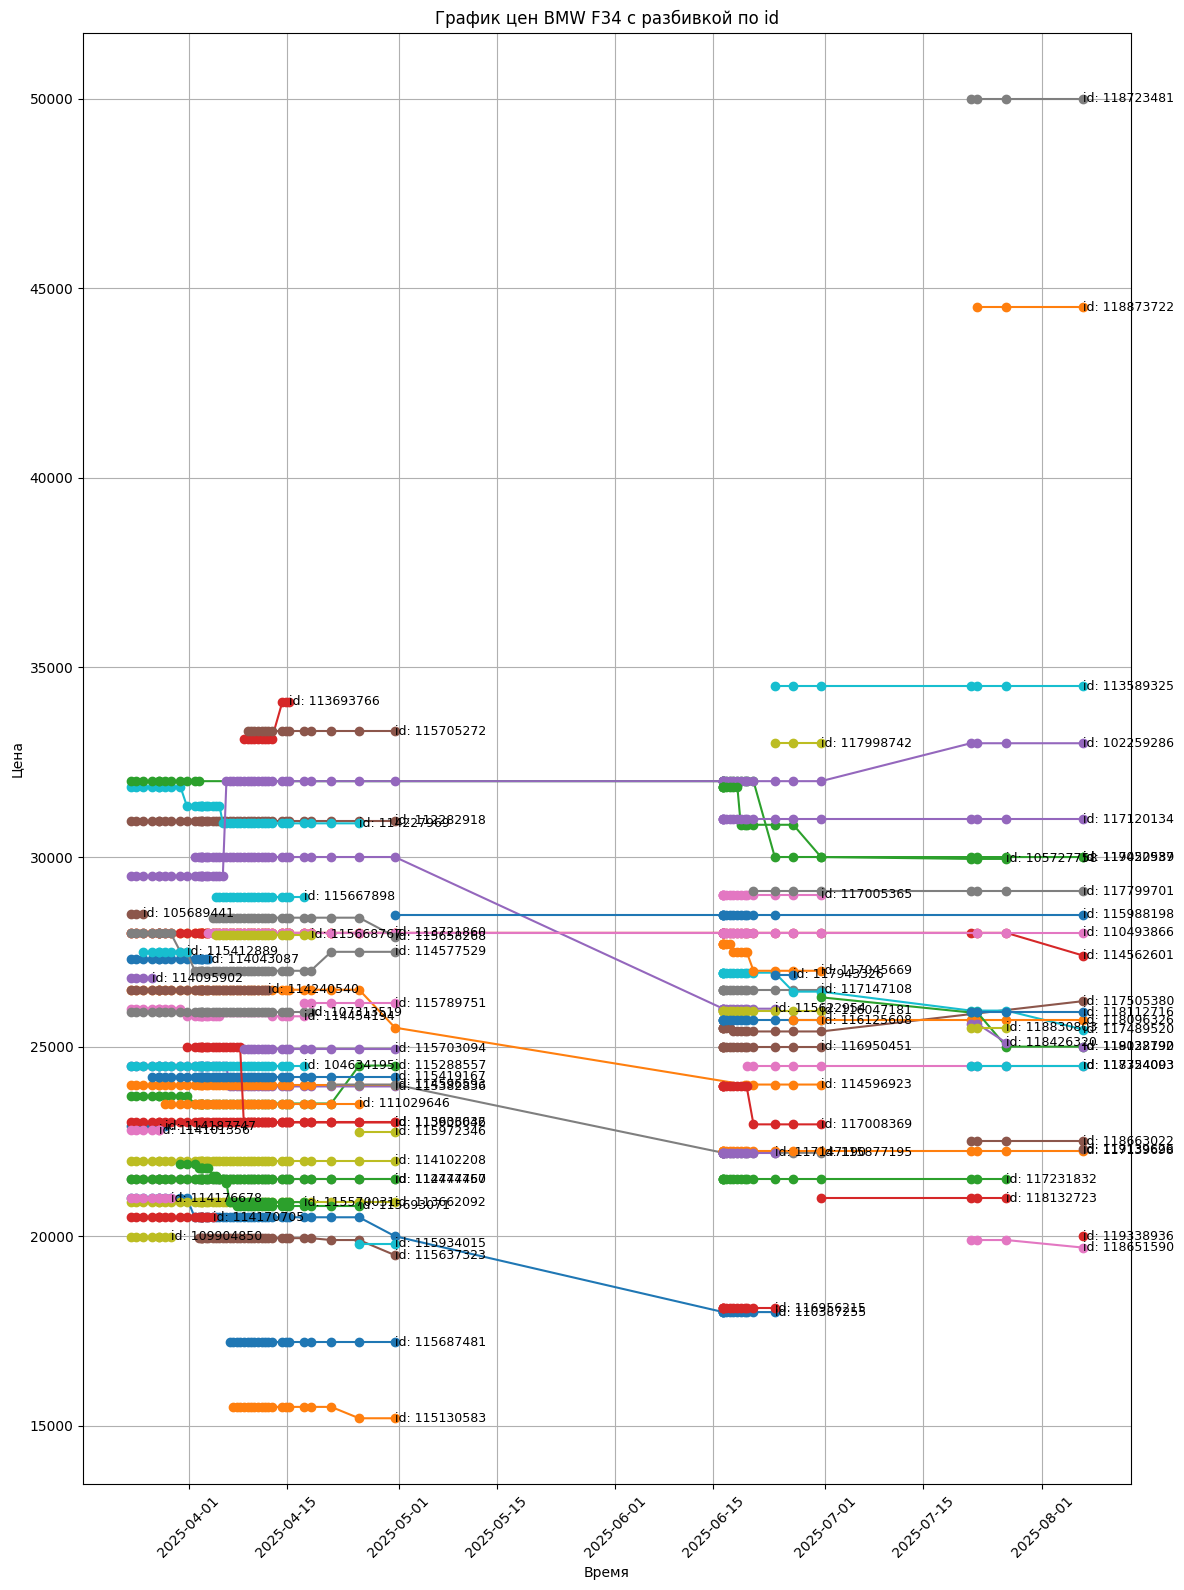

In [3]:
plot_price_by_date(bmw_history, 'BMW F34')

In [4]:
bmw_insights = find_insights(bmw_history)
show_insights_html(bmw_insights)

## AUDI A4 B6

In [5]:
audi_history = list(filter(lambda x: x['model'] == 'AUDI A4 B6', history))

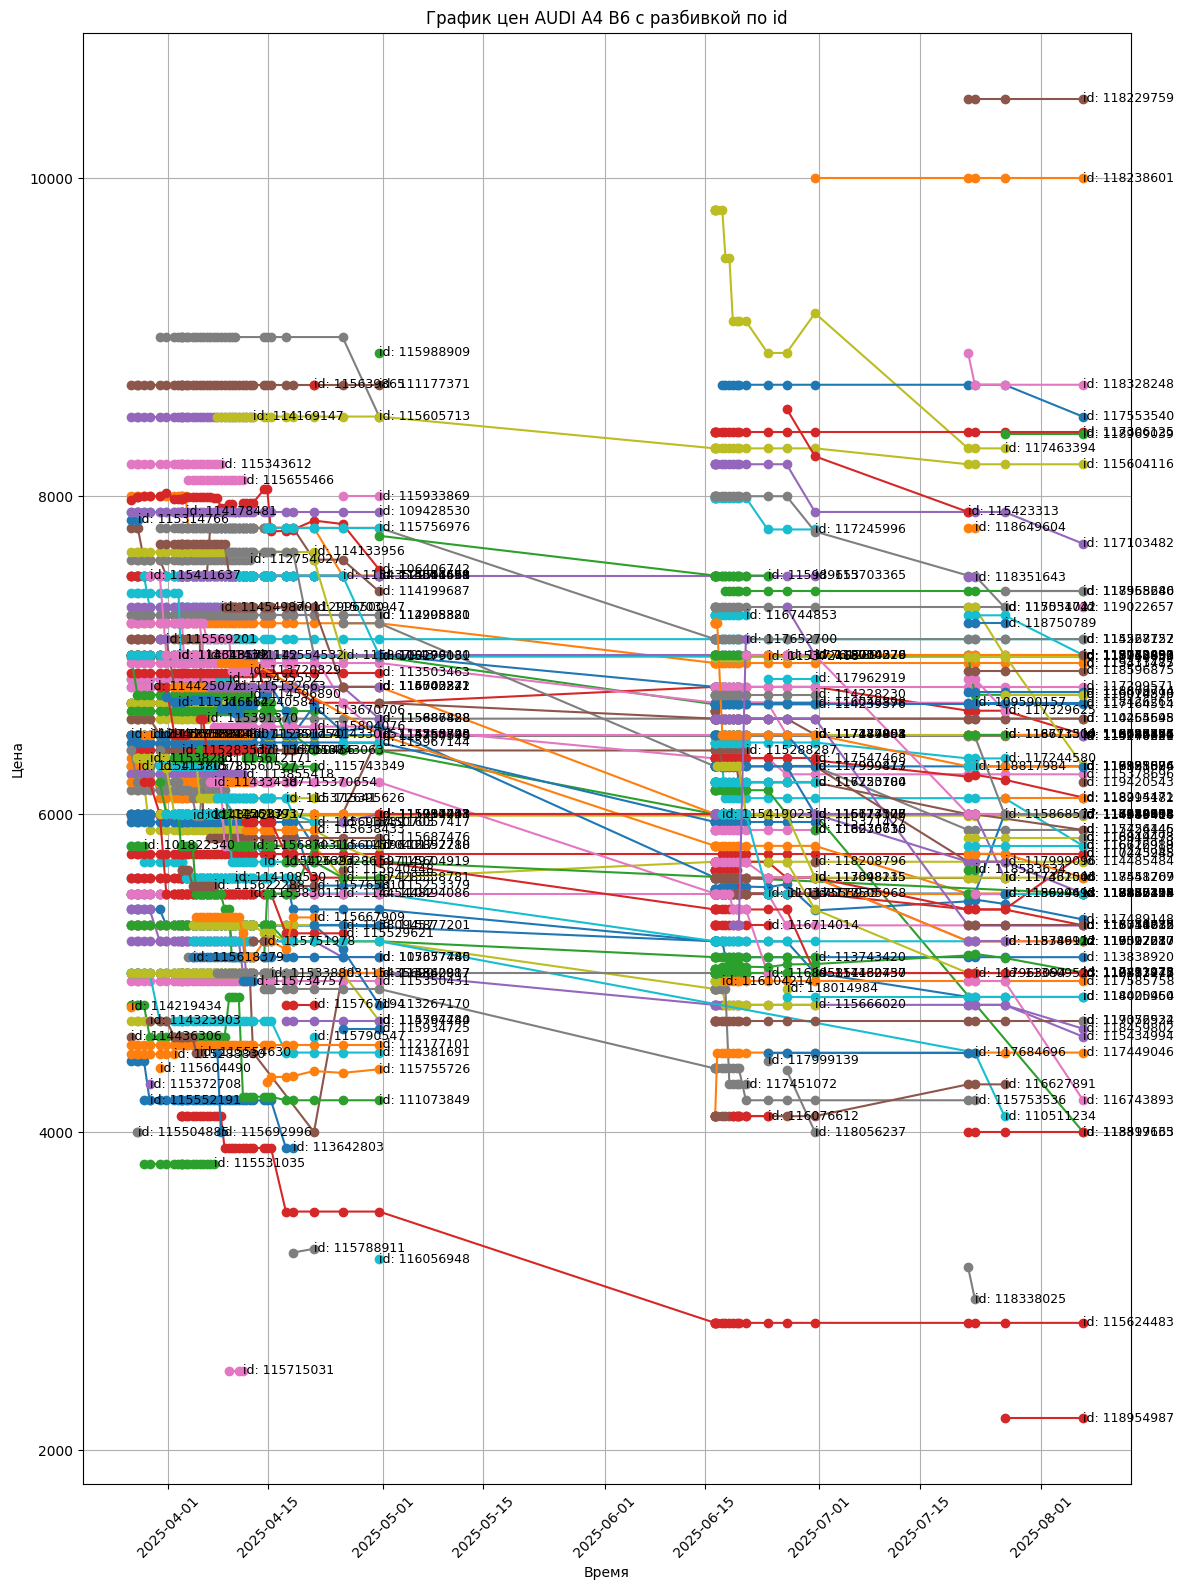

In [6]:
plot_price_by_date(audi_history, 'AUDI A4 B6')

In [7]:
audi_insights = find_insights(audi_history)
show_insights_html(audi_insights)

## VOLVO XC60 I

In [8]:
volvo_xc60_i_history = list(filter(lambda x: x['model'] == 'VOLVO XC60 I', history))

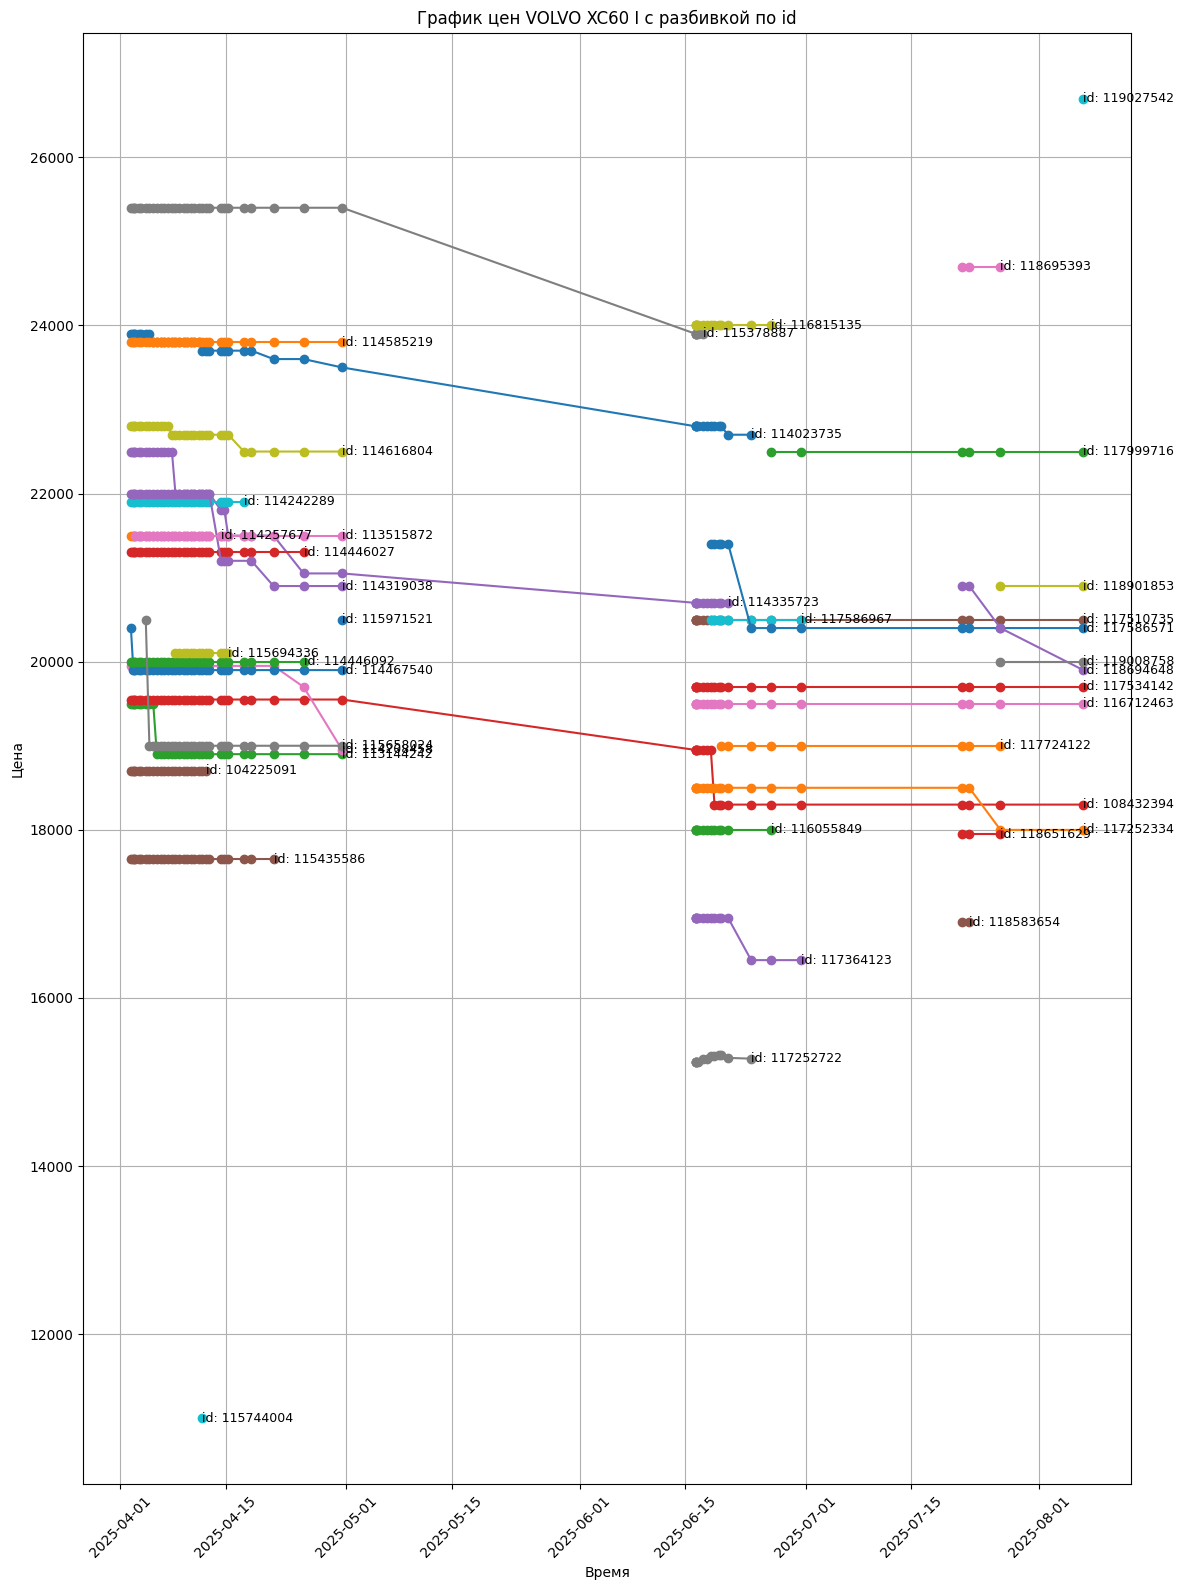

In [9]:
plot_price_by_date(volvo_xc60_i_history, 'VOLVO XC60 I')

In [10]:
volvo_xc60_i_insights = find_insights(volvo_xc60_i_history)
show_insights_html(volvo_xc60_i_insights)

## Ford S-MAX I

In [11]:
ford_smax_i_history = list(filter(lambda x: x['model'] == 'Ford S-MAX I', history))

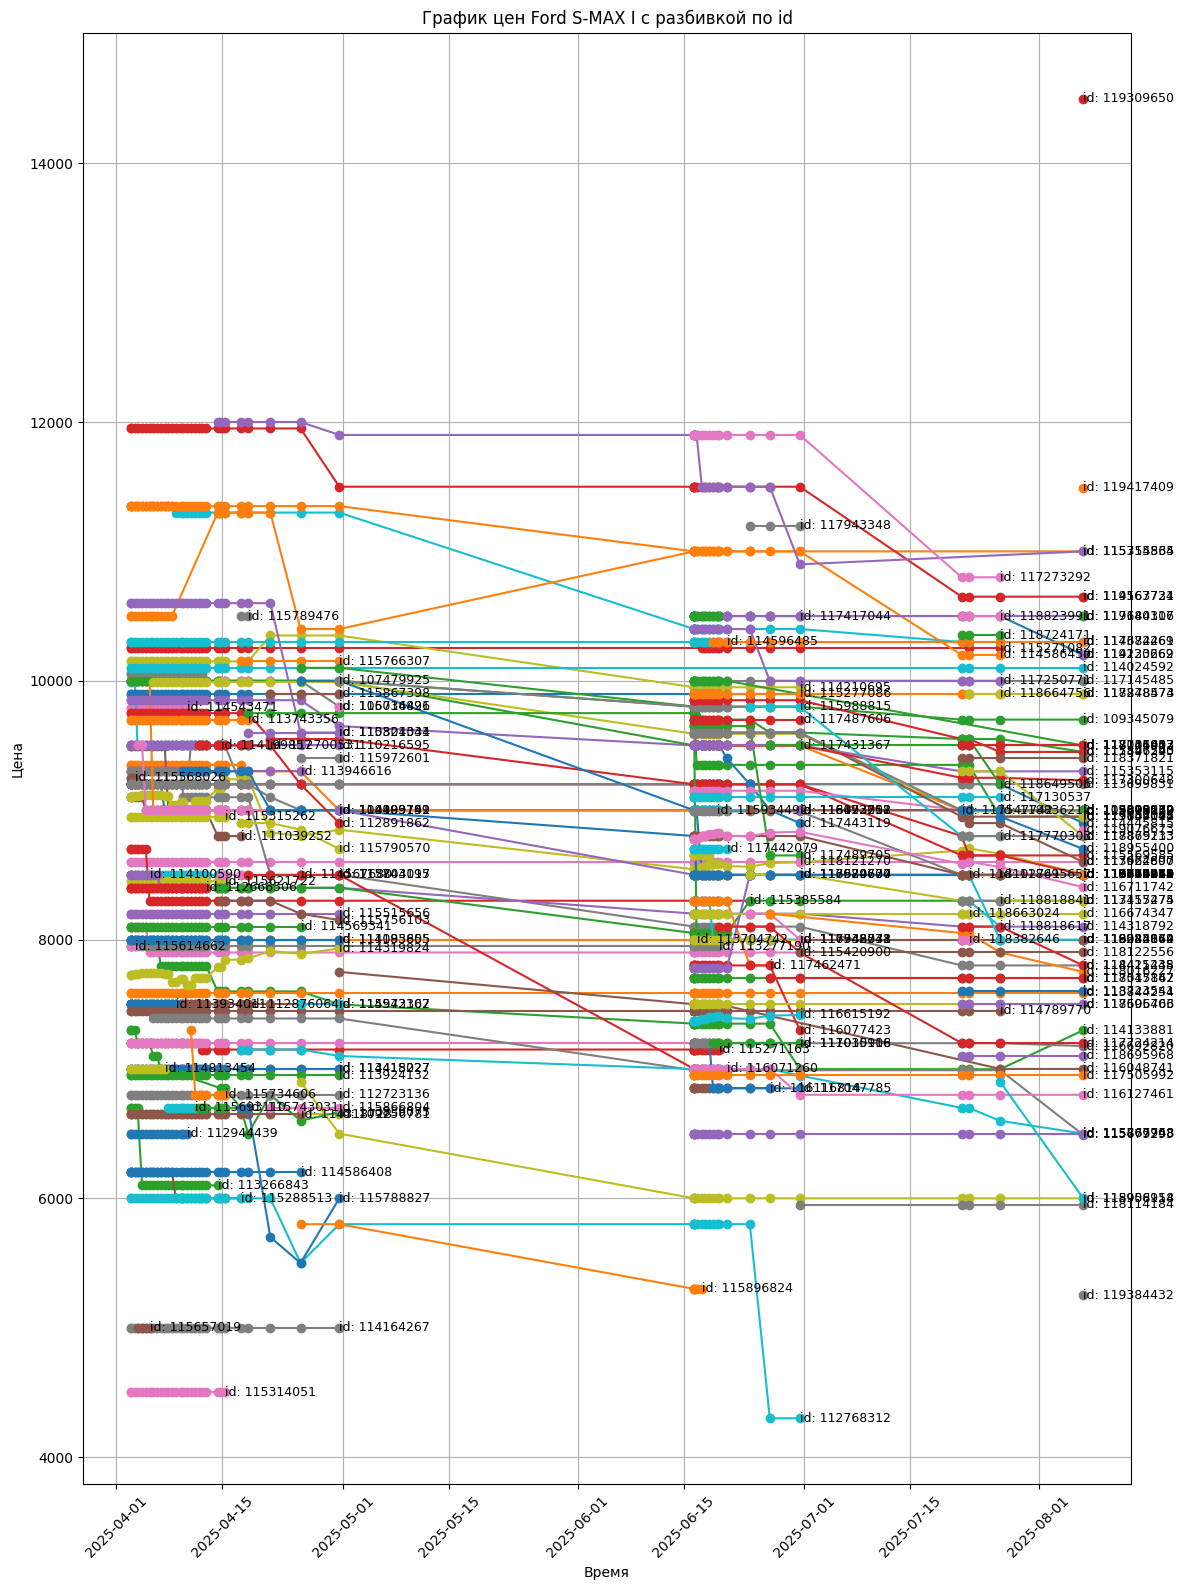

In [12]:
plot_price_by_date(ford_smax_i_history, 'Ford S-MAX I')

In [13]:
ford_smax_i_insights = find_insights(ford_smax_i_history)
show_insights_html(ford_smax_i_insights)

## Kia Carnival III

In [14]:
kia_carnival_iii_history = list(filter(lambda x: x['model'] == 'Kia Carnival III', history))

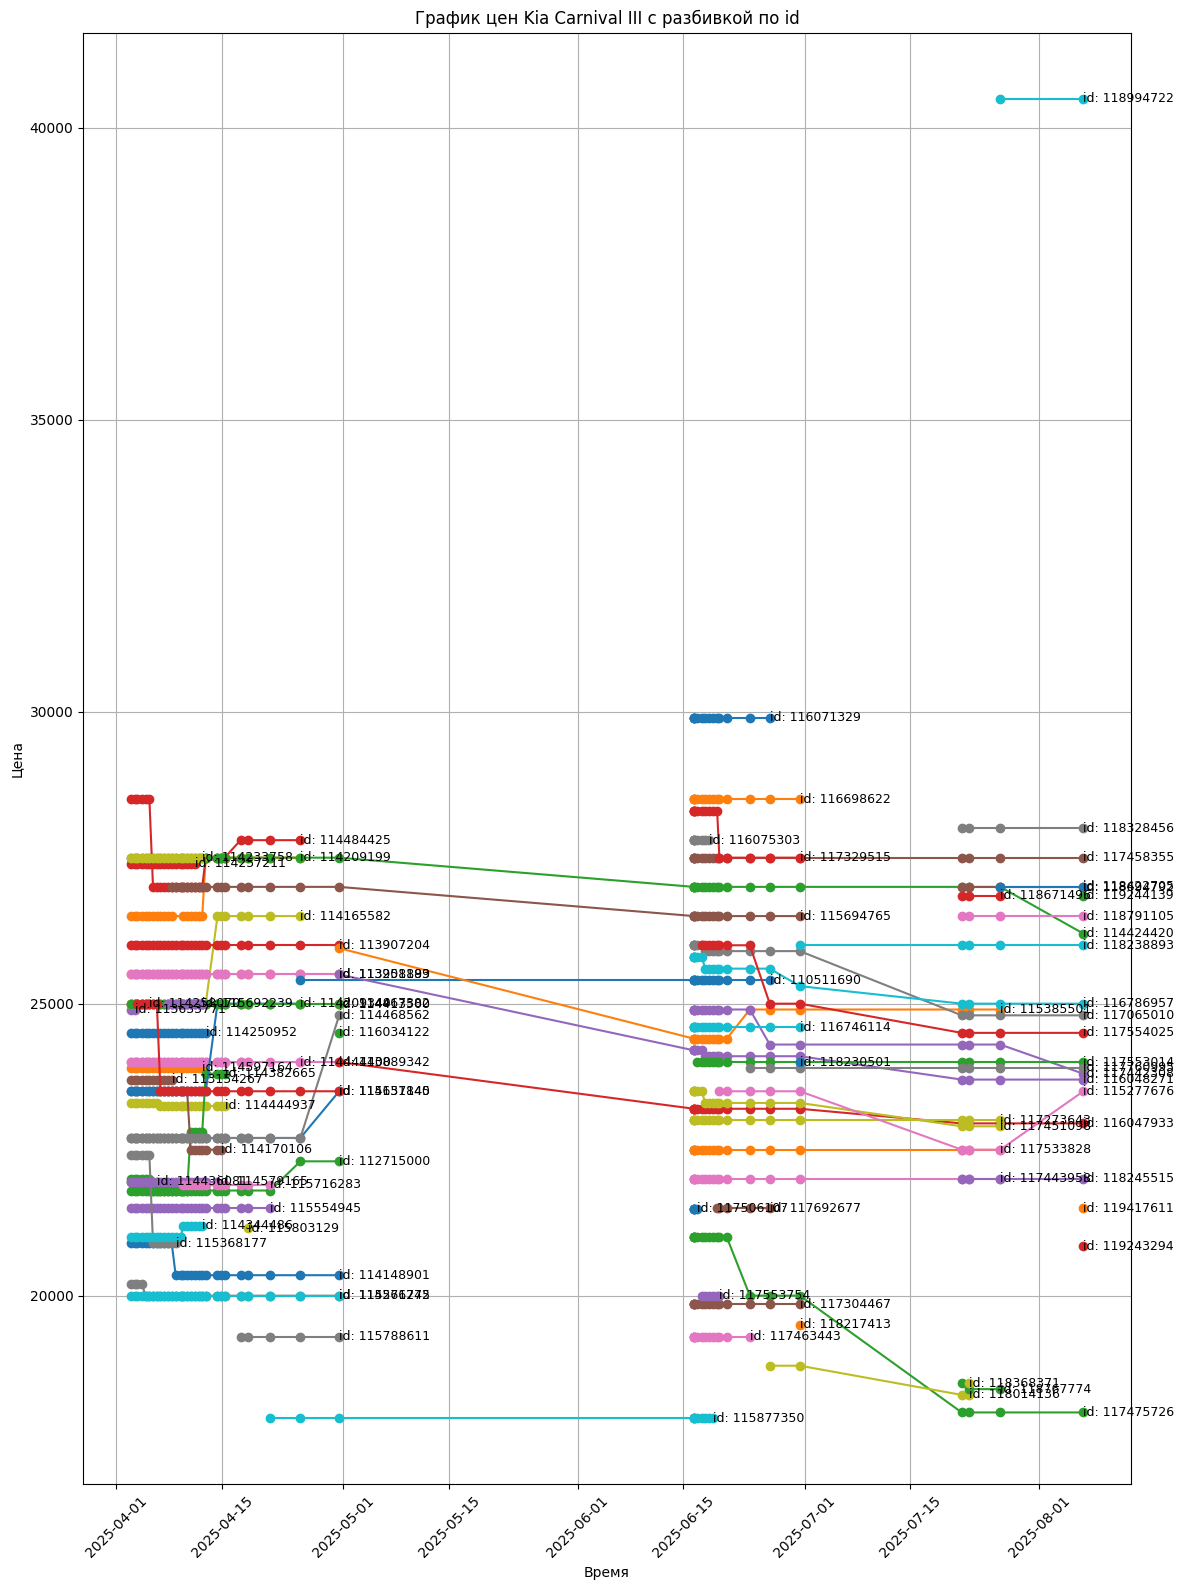

In [15]:
plot_price_by_date(kia_carnival_iii_history, 'Kia Carnival III')

In [16]:
kia_carnival_iii_insights = find_insights(kia_carnival_iii_history)
show_insights_html(kia_carnival_iii_insights)

## Subaru Impreza III

In [17]:
subaru_impreza_iii_history = list(filter(lambda x: x['model'] == 'Subaru Impreza III', history))

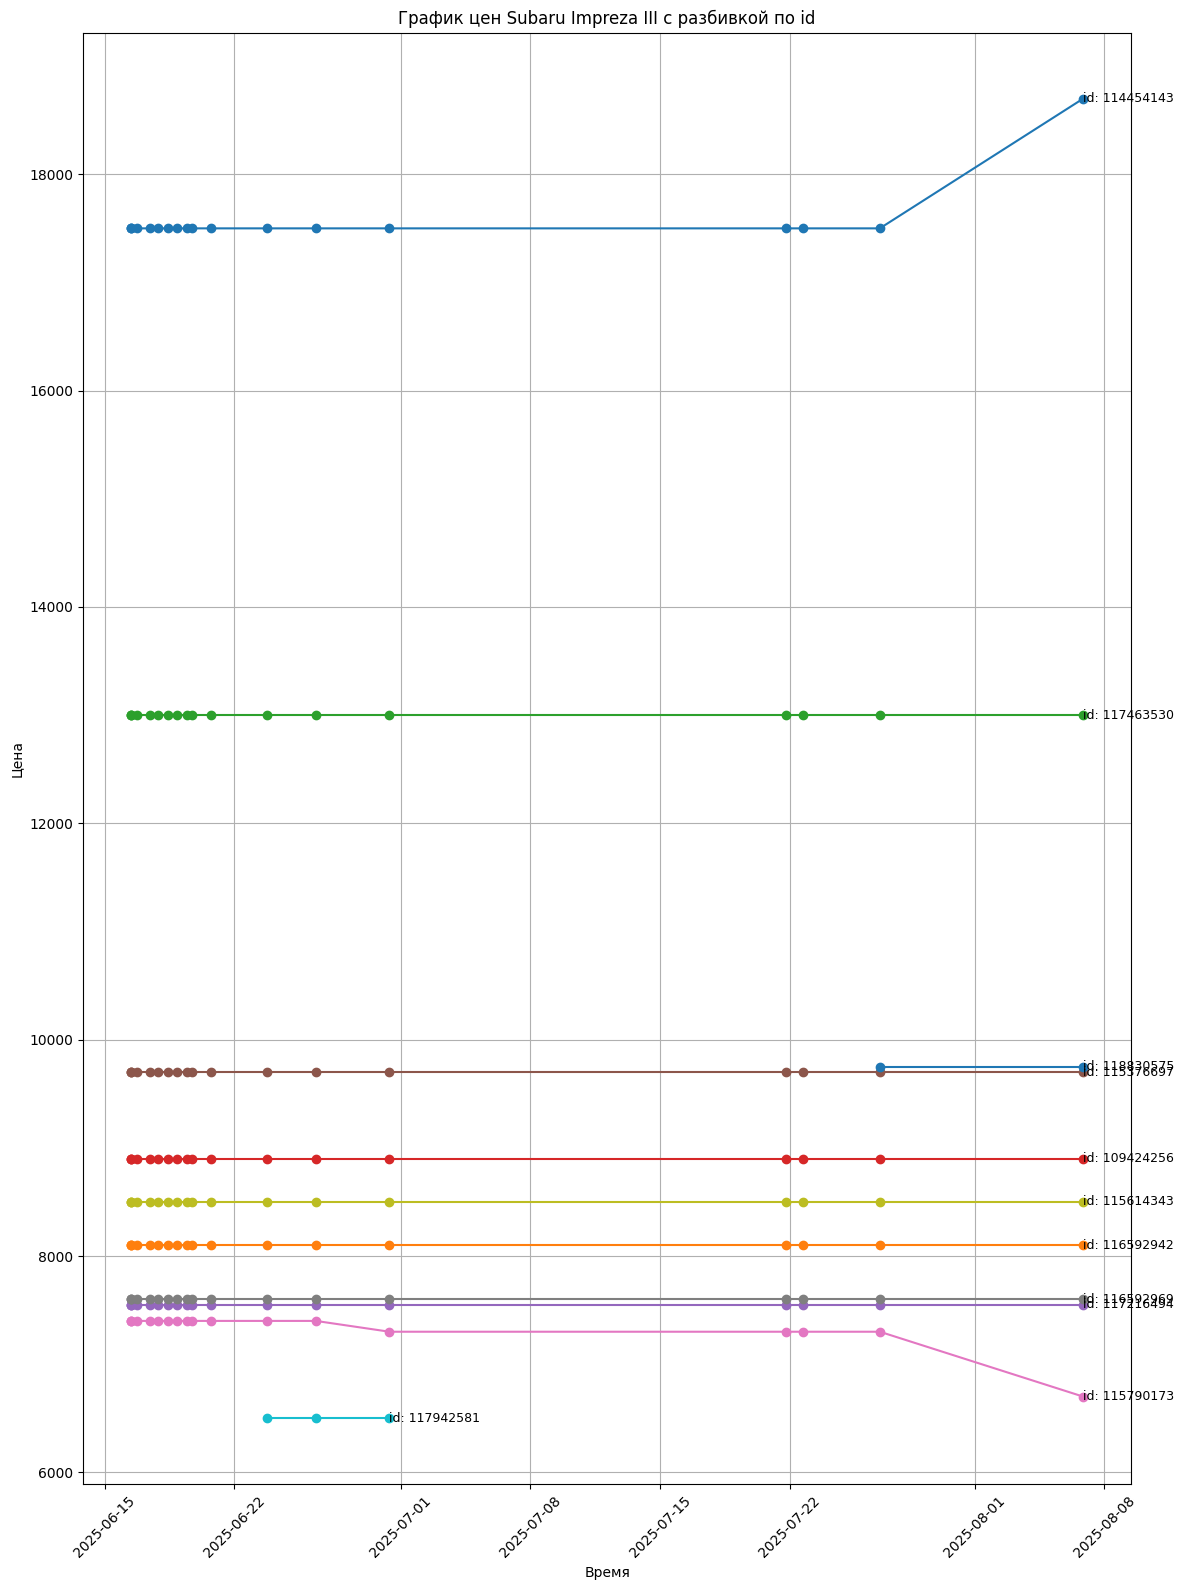

In [18]:
plot_price_by_date(subaru_impreza_iii_history, 'Subaru Impreza III')

In [19]:
subaru_impreza_iii_insights = find_insights(subaru_impreza_iii_history)
show_insights_html(subaru_impreza_iii_insights)

## Subaru Impreza III Автомат

In [20]:
subaru_impreza_iii_auto_history = list(filter(lambda x: x['model'] == 'Subaru Impreza III Автомат', history))

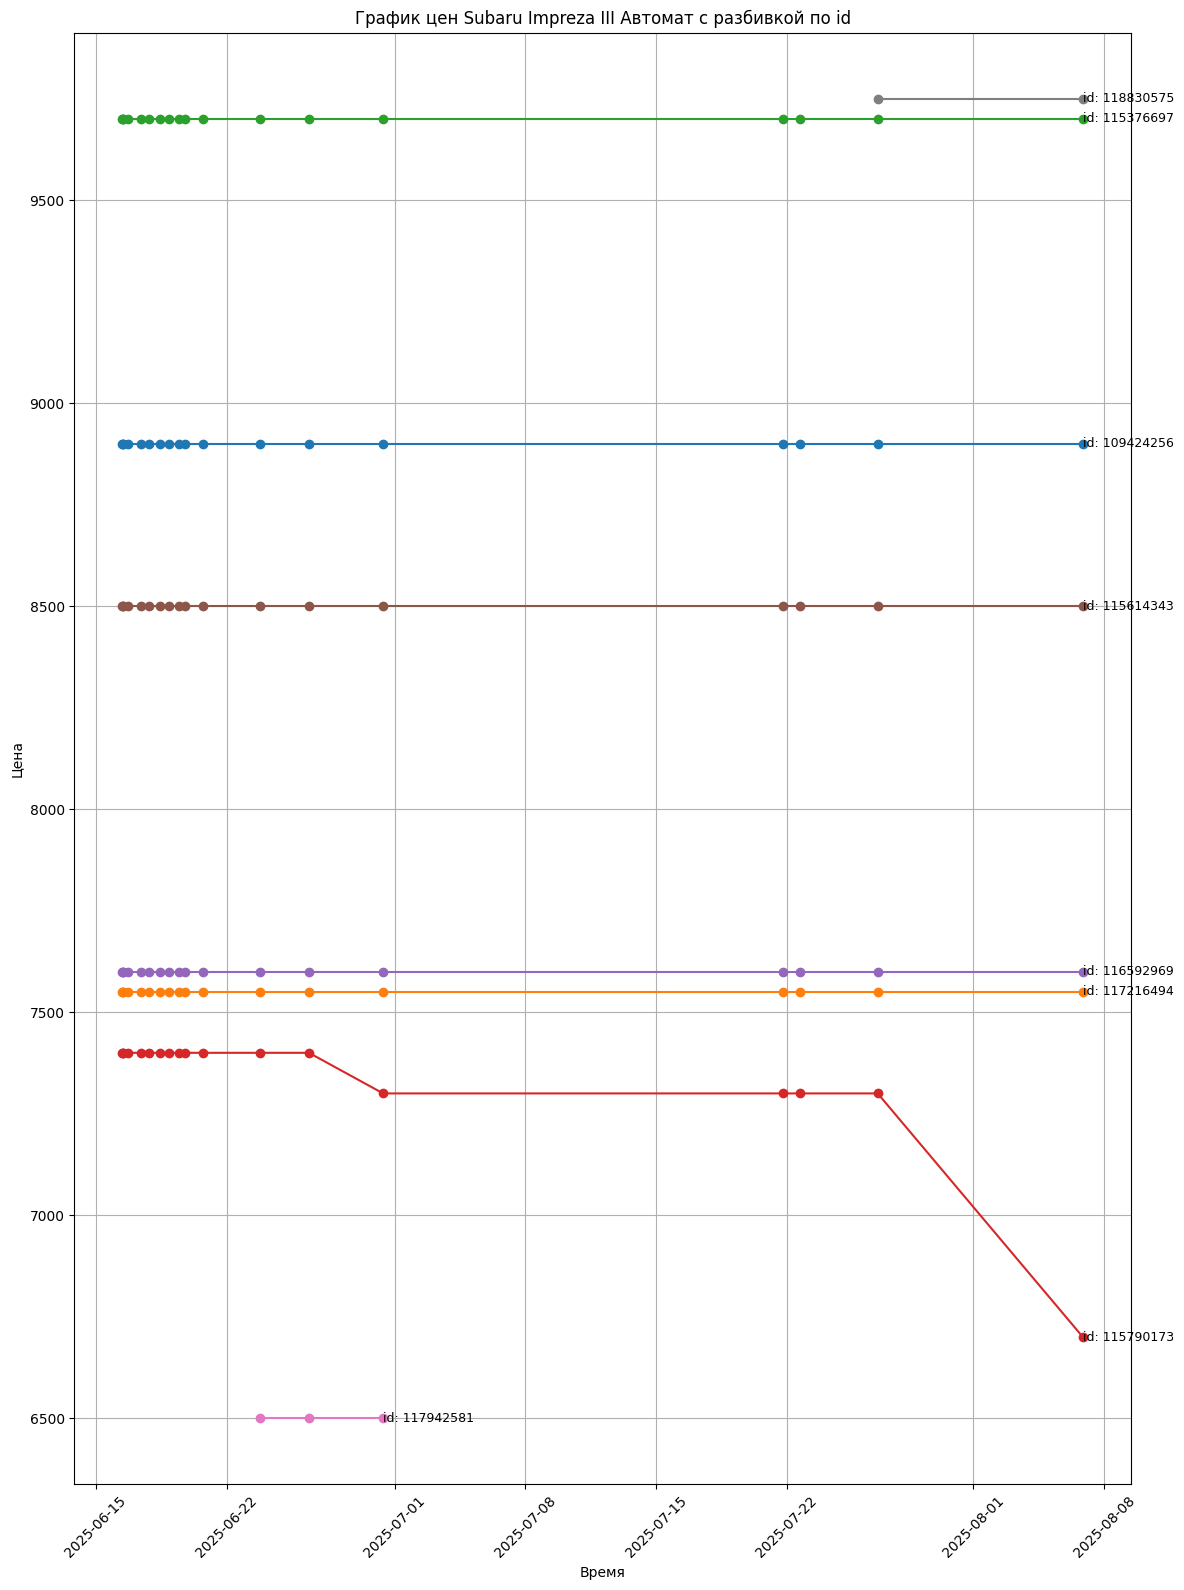

In [21]:
plot_price_by_date(subaru_impreza_iii_auto_history, 'Subaru Impreza III Автомат')

In [22]:
subaru_impreza_iii_auto_insights = find_insights(subaru_impreza_iii_auto_history)
show_insights_html(subaru_impreza_iii_auto_insights)

## BMW X1 E84

In [23]:
bmw_x1_e84_history = list(filter(lambda x: x['model'] == 'BMW X1 E84', history))

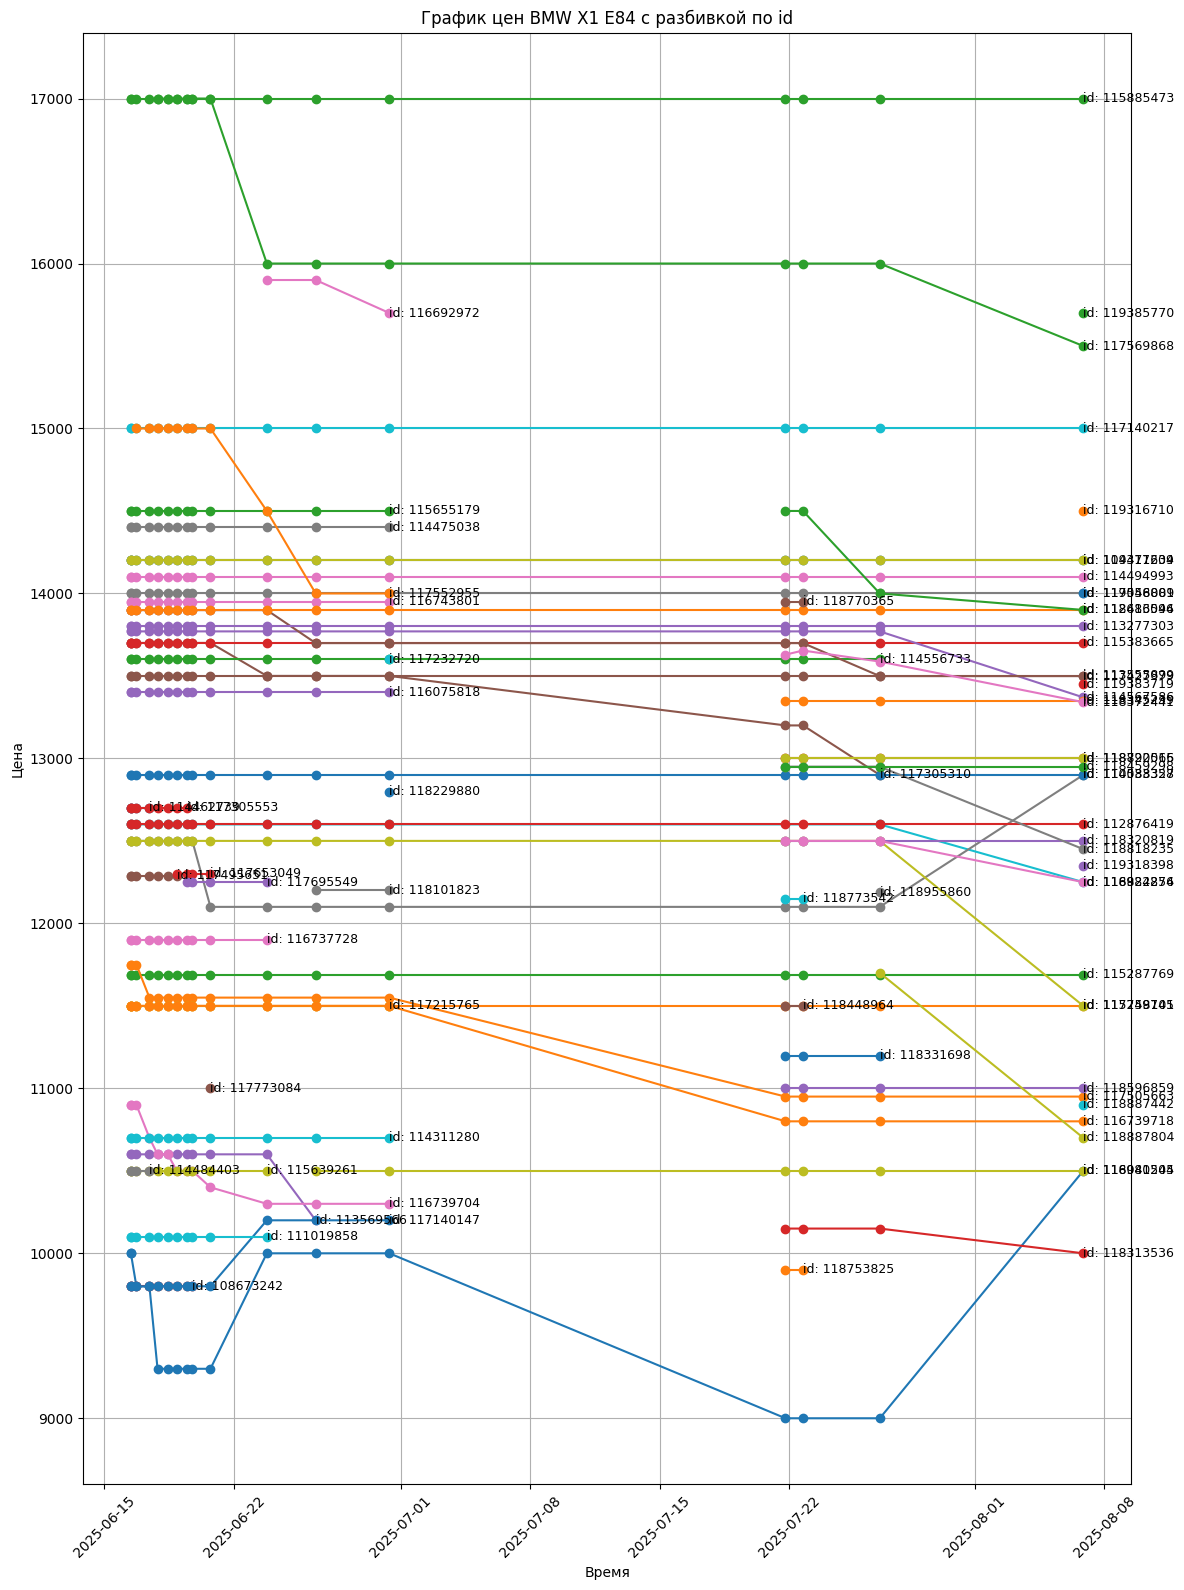

In [24]:
plot_price_by_date(bmw_x1_e84_history, 'BMW X1 E84')

In [25]:
bmw_x1_e84_insights = find_insights(bmw_x1_e84_history)
show_insights_html(bmw_x1_e84_insights)

## Volvo S40 II

In [26]:
volvo_s40_ii_history = list(filter(lambda x: x['model'] == 'Volvo S40 II', history))

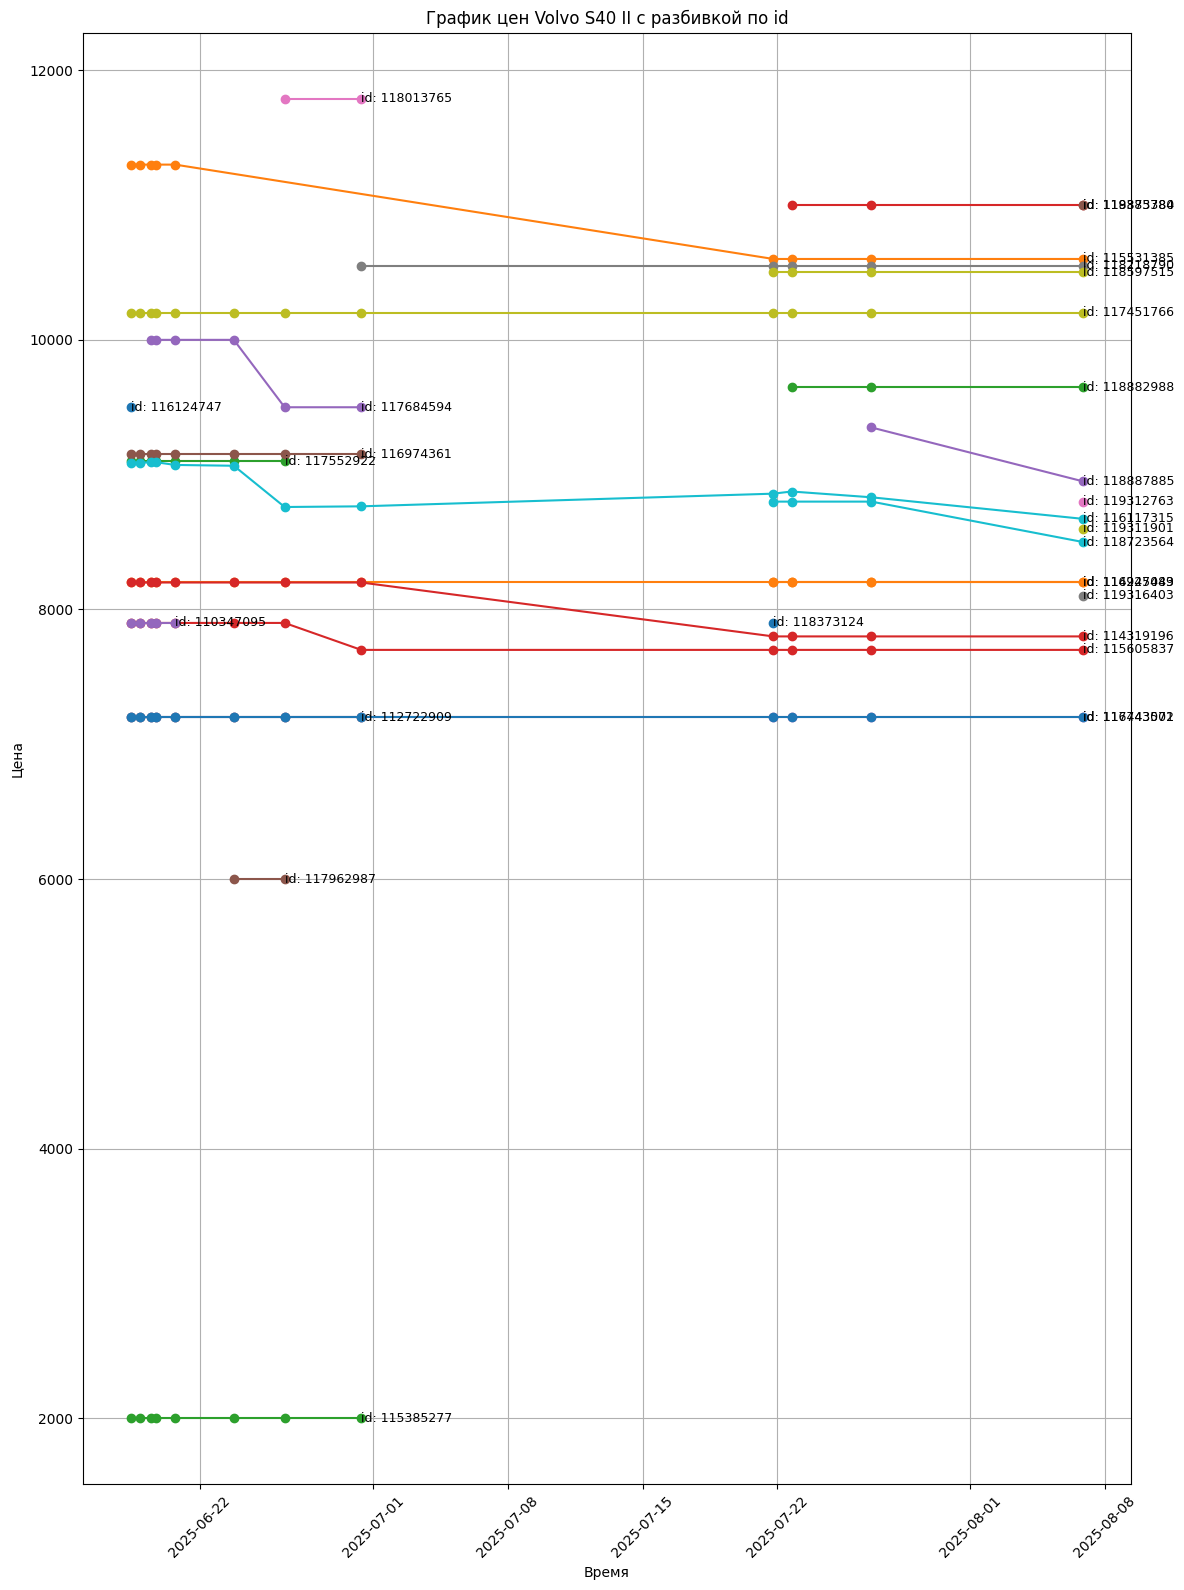

In [27]:
plot_price_by_date(volvo_s40_ii_history, 'Volvo S40 II')

In [28]:
volvo_s40_ii_insights = find_insights(volvo_s40_ii_history)
show_insights_html(volvo_s40_ii_insights)